In [5]:
import os
import mat73
import numpy as np
import pandas as pd
import time
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
np.random.seed(0)

In [6]:

def load_dataframe():
    data_dict = mat73.loadmat('spect_phee2monkey_mel_cell_nopadding_streched_50x50.mat')
    data_dict["spect"] = [data_dict["spect"][:, :, i] for i in range(data_dict["spect"].shape[2])]
    df = pd.DataFrame(data_dict)
    for name in ['callee', 'caller', 'expname']:
        df[name] = df[name].apply(lambda x: x[0])
    df.loc[df["callee"] == "Brhama", "callee"] = "Brahma"
    df.loc[df["caller"] == "Brhama", "caller"] = "Brahma"
    dates_str = df["expname"].astype("string").apply(lambda x: x.replace("exp_", "")[:10])
    df["date"] = pd.to_datetime(dates_str, format='%Y_%m_%d')
    return df

In [7]:
def show_cm(cmn,title,labels,average_oob_score,to_save = False, directory_to_save_in = None):
    fig, ax = plt.subplots(figsize=(15,15))
    f = sns.heatmap(cmn, annot=True, fmt=".1%", linewidths=1.0, square=1,cmap='rocket_r')
    plt.title(title, fontsize=25)
    plt.xlabel('Predicted Label', fontsize=20)
    plt.ylabel('True Label', fontsize=20)
    _ = ax.set_xticklabels(labels)
    _ = plt.xticks(rotation=70)
    _ = ax.set_yticklabels(labels)
    _ = plt.yticks(rotation=0)

    if to_save:
        if not os.path.exists(directory_to_save_in):
            os.makedirs(directory_to_save_in)
        plt.savefig(directory_to_save_in+f"/{title}.pdf",format='pdf')

In [8]:
df= load_dataframe()

72.98686957359314


In [9]:
df = df[df['caller'] != 'Chaos']

In [10]:
def create_derivative_max_signal_amplitude_df(df, make_derivative = True, max_signal=True, make_amplitude=True):

    column_names = ['callee','caller','expname','date']
    if make_derivative:
        column_names.extend([f"diff_{x}" for x in(range(1,50))])
    if max_signal:
        column_names.extend(f"max_signal_{x}" for x in range(1,51))
    if make_amplitude:
        column_names.extend(f"amplitude_{x}" for x in range(1,51))
    exp_dict= {}

    counter = 0
    for exp in tqdm.tqdm(df.iterrows()):

        exp_info_series = pd.Series([exp[1]["callee"],exp[1]["caller"],exp[1]["expname"],exp[1]["date"]])
        max_row_indices = np.argmax(exp[1]["spect"],axis=0)
        exp_derivatives = pd.Series(np.diff(max_row_indices))
        exp_amplitudes = pd.Series(np.amax(exp[1]["spect"],axis=0))
        # make features
        if make_derivative:
            exp_info_series = exp_info_series.append(exp_derivatives,ignore_index=True)
        if max_signal:
            exp_info_series = exp_info_series.append(pd.Series(max_row_indices),ignore_index=True)
        if make_amplitude:
            exp_info_series = exp_info_series.append(exp_amplitudes,ignore_index=True)

        exp_info_series.index = column_names

        #using dict for fast adding speed
        exp_dict[counter] = exp_info_series
        counter +=1

    return pd.DataFrame.from_dict(exp_dict,orient='index')



In [11]:
df_derivative = create_derivative_max_signal_amplitude_df(df, make_derivative = False)

47995it [00:57, 832.22it/s] 


In [21]:
def pred_caller_to_collees_train_test(df, caller_label, callees_to_drop = [], repeat_amount = 100):
    df_caller = df[df["caller"] == caller_label].drop(columns="caller")
    df_caller = df_caller[~df_caller["callee"].isin(callees_to_drop)]
    X, y = df_caller.drop(columns="callee"),df_caller["callee"]
    labels = y.unique()
    cm_list = []
    oob_score_ls = []
    us = RandomUnderSampler()
    rfc = RandomForestClassifier(oob_score=True)
    for i in tqdm.tqdm(range(repeat_amount)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
        X_train_resampled, y_train_resampled = us.fit_resample(X_train,y_train)
        X_test_resampled, y_test_resampled = us.fit_resample(X_test,y_test)
        rfc.fit(X_train_resampled,y_train_resampled)
        oob_score = rfc.oob_score_
        y_pred = rfc.predict(X_test_resampled)
        cm = confusion_matrix(y_true=y_test_resampled, y_pred=y_pred, labels=np.unique(y_test_resampled))
        cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm_list.append(cmn)
        oob_score_ls.append(oob_score)
    return np.mean(cm_list, axis=0), np.mean(oob_score_ls), labels

In [22]:
directory_to_save_in = "Callers Callee Predictions Using Max Signal, Derivative & Amplitude"

100%|██████████| 100/100 [03:23<00:00,  2.04s/it]


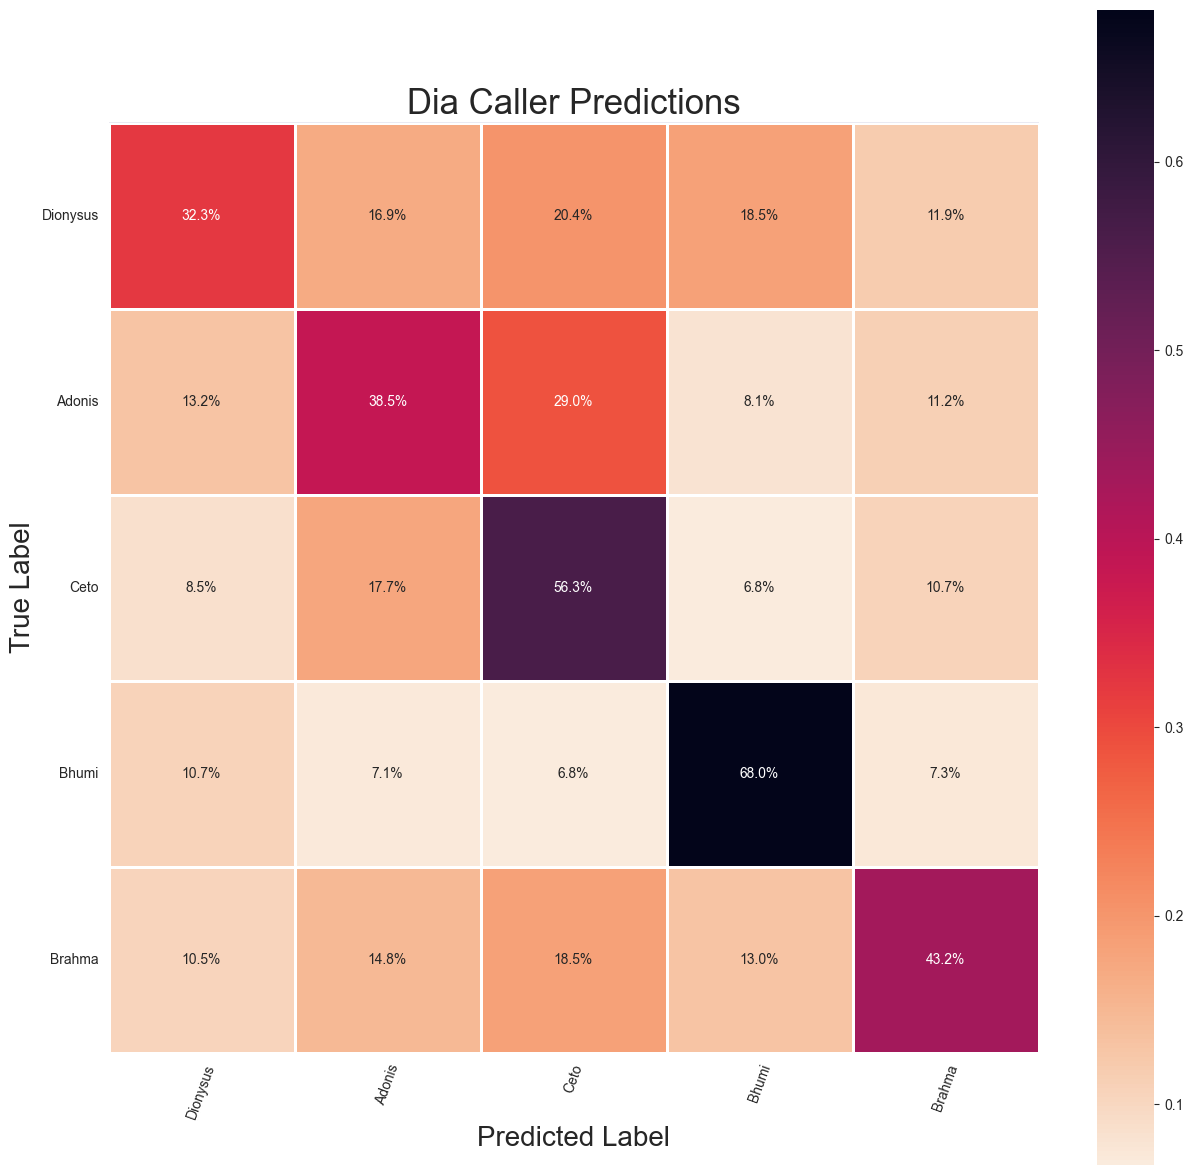

In [23]:
cmn, oob_score,labels =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),'Dia',['Ella'])
title = "Dia Caller Predictions"
show_cm(cmn,title,labels,oob_score,True,directory_to_save_in)

100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


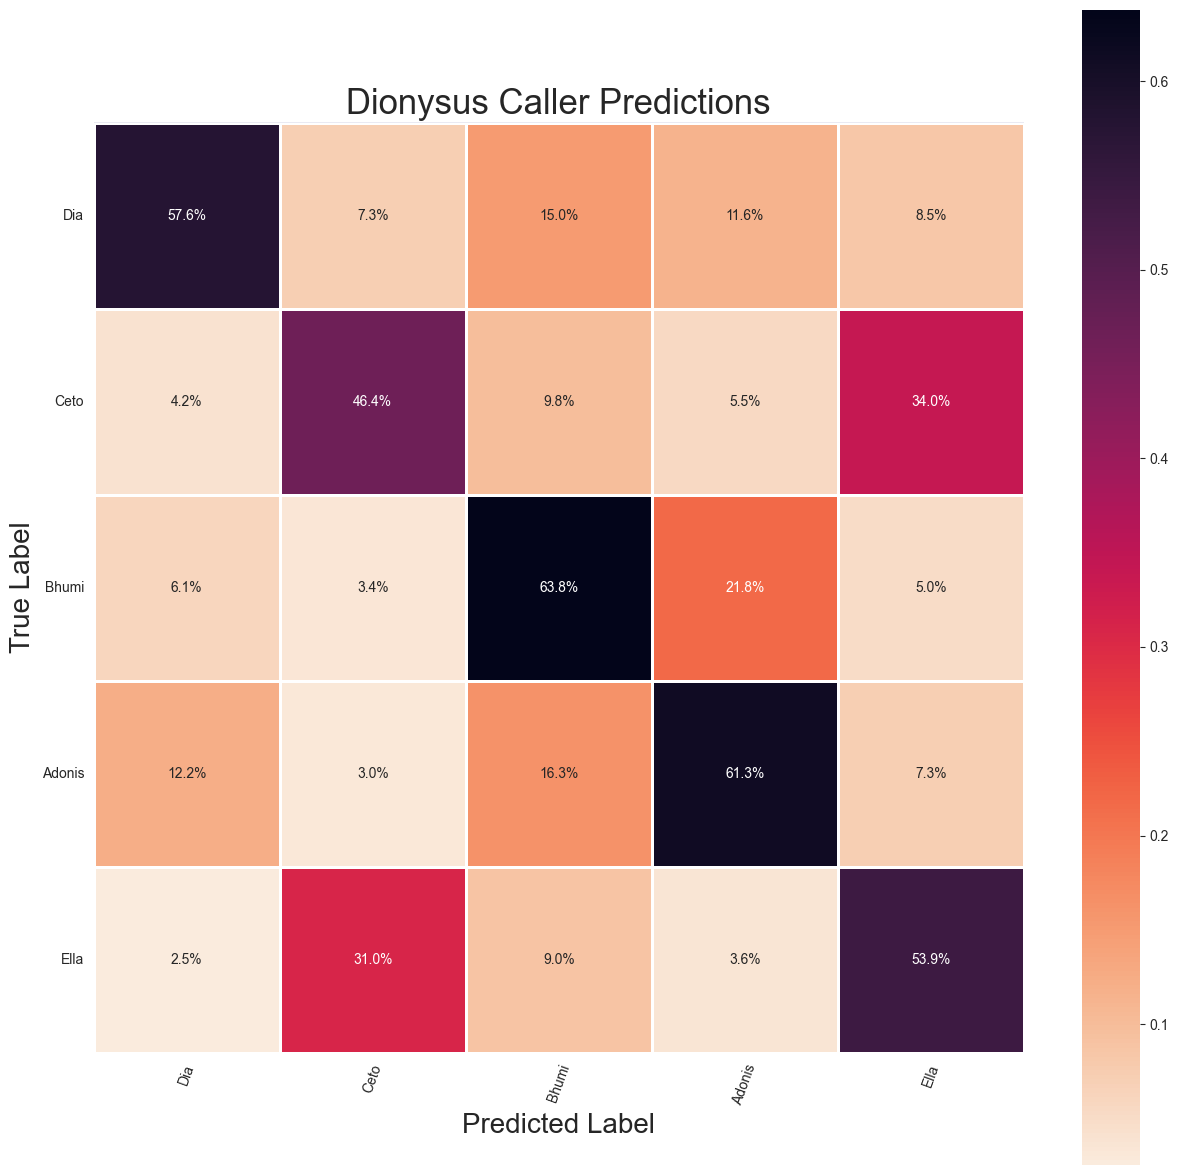

In [24]:
cmn_dio, oob_score_dio,labels_dio =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Dionysus", ["Brahma", "Chaos"])
title_dio = "Dionysus Caller Predictions"
show_cm(cmn_dio,title_dio,labels_dio,oob_score_dio,True,directory_to_save_in)

100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


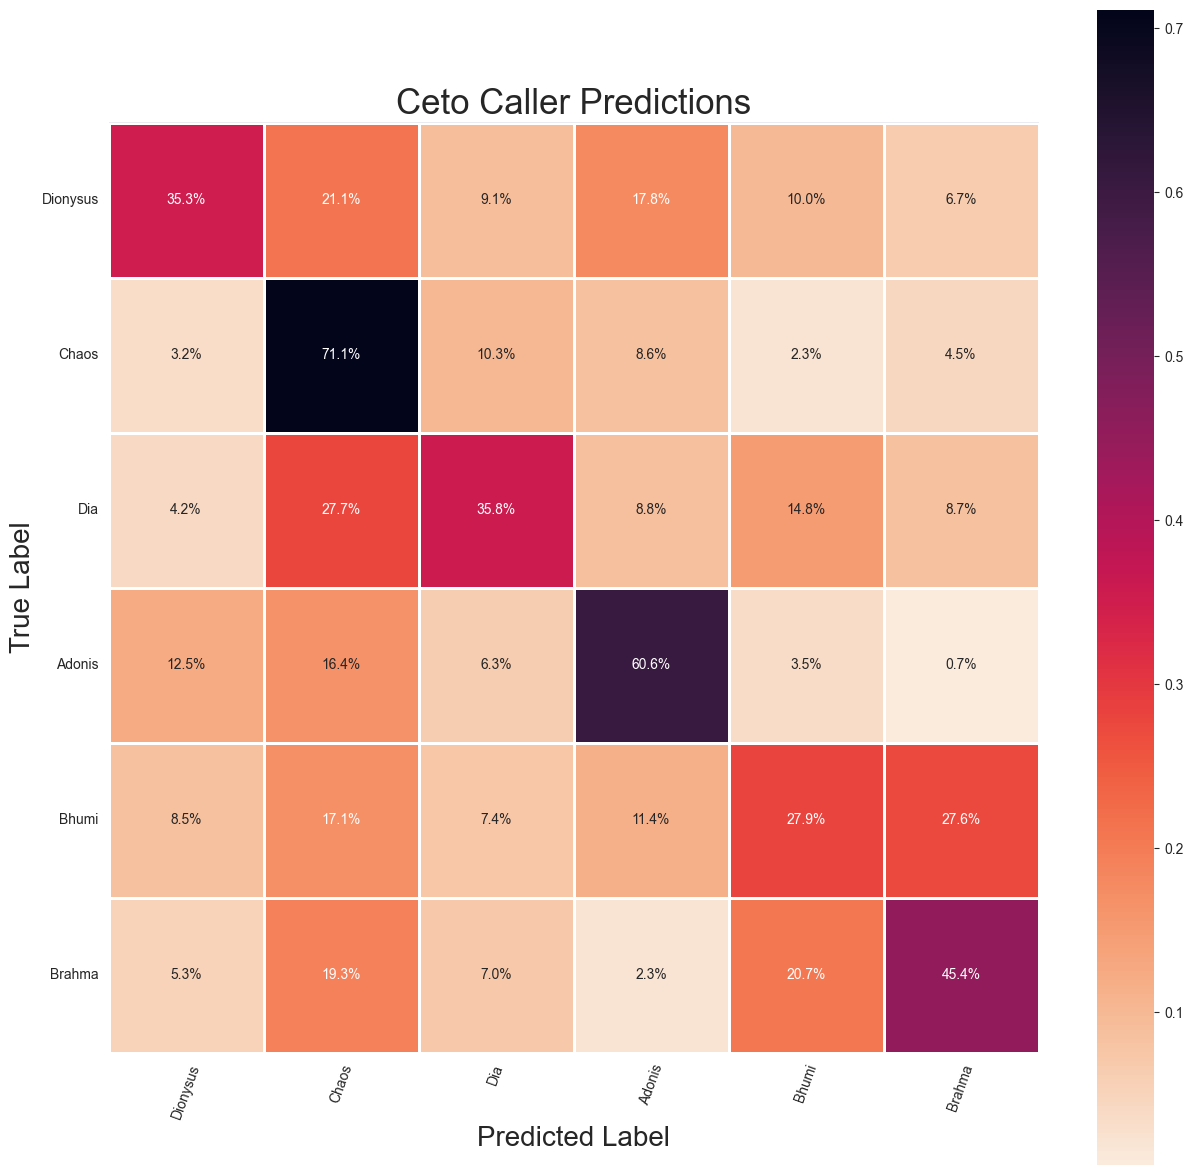

In [25]:
cmn_ceto, oob_score_ceto,labels_ceto =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Ceto")
title_ceto = "Ceto Caller Predictions"
show_cm(cmn_ceto,title_ceto,labels_ceto,oob_score_ceto,True,directory_to_save_in)

100%|██████████| 100/100 [00:34<00:00,  2.86it/s]


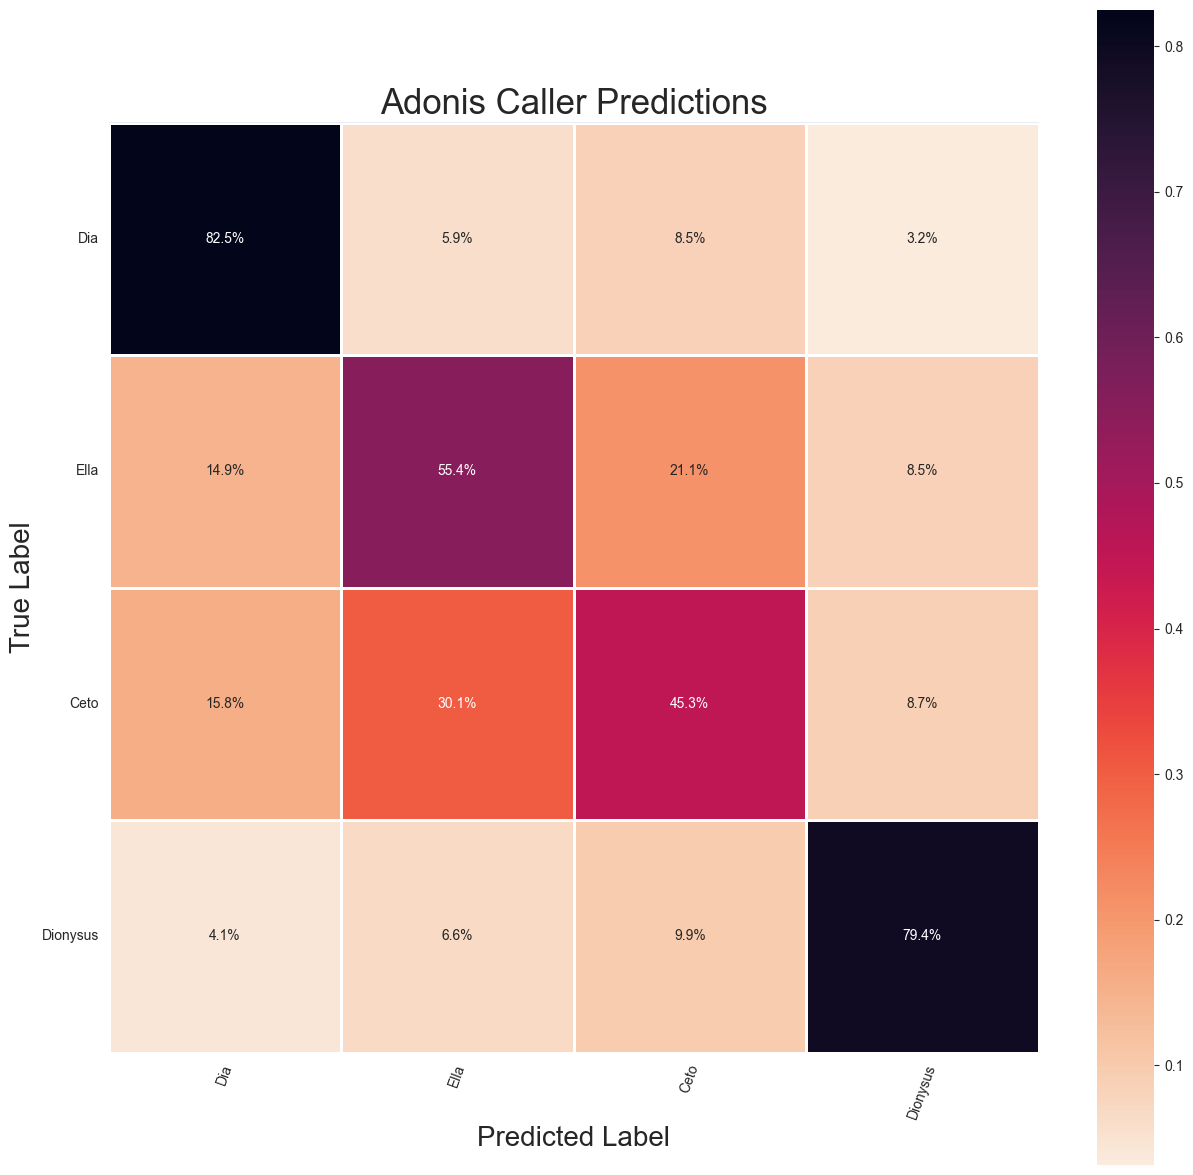

In [26]:
cmn_adonis, oob_score_adonis,labels_adonis =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Adonis")
title_adonis = "Adonis Caller Predictions"
show_cm(cmn_adonis,title_adonis,labels_adonis,oob_score_adonis,True,directory_to_save_in)

100%|██████████| 100/100 [00:29<00:00,  3.35it/s]


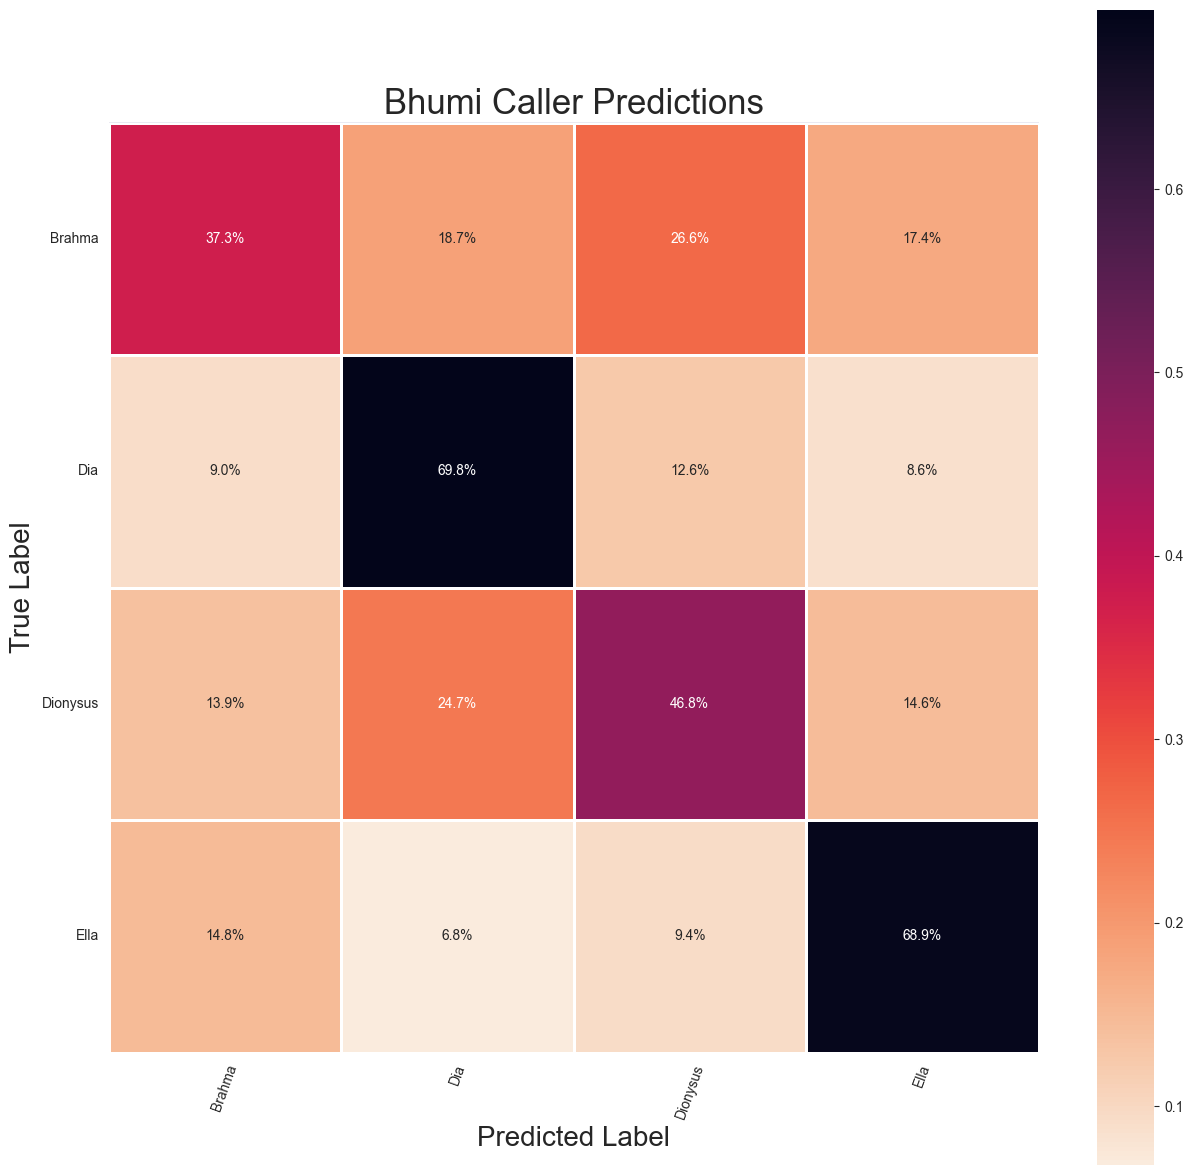

In [27]:
cmn_bhumi, oob_score_bhumi,labels_bhumi =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Bhumi", ["Adonis", "Ceto"])
title_bhumi = "Bhumi Caller Predictions"
show_cm(cmn_bhumi,title_bhumi,labels_bhumi,oob_score_bhumi,True,directory_to_save_in)

100%|██████████| 100/100 [00:35<00:00,  2.78it/s]


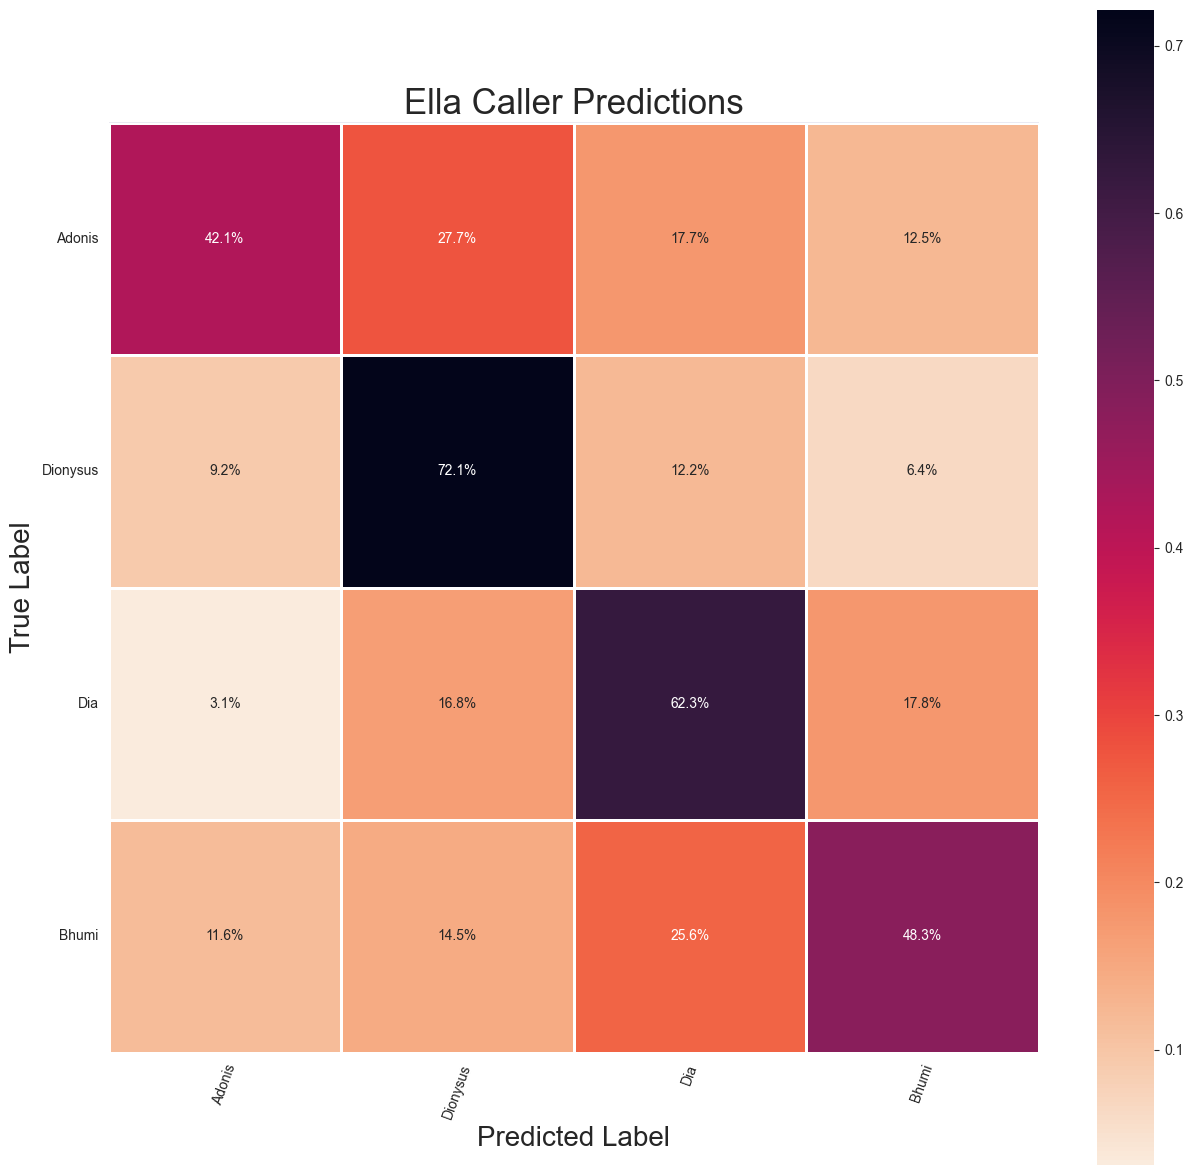

In [28]:
cmn_ella, oob_score_ella,labels_ella =  pred_caller_to_collees_train_test(df_derivative.drop(columns=["expname","date"]),"Ella")
title_ella = "Ella Caller Predictions"
show_cm(cmn_ella,title_ella,labels_ella,oob_score_ella,True,directory_to_save_in)